In [21]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [23]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [24]:
data_dir='/content/drive/MyDrive/PlantDisease/Data'
categories=os.listdir(data_dir)

#Load images and labels
images=[]
labels=[]

for category in categories:
  print(category)
  folder_path=os.path.join(data_dir,category)
  for img_file in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img_file)
    img=cv2.imread(img_path)
    if img is not None:
      img=cv2.resize(img,(64,64)) #resize to uniform size
      images.append(img)
      labels.append(category)

#convert images and labels to numpy arrays
images=np.array(images)


Tomato___healthy
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___Target_Spot
Tomato___Late_blight
Tomato___Early_blight
Tomato___Bacterial_spot


In [26]:
#convert to numpy arrays
x=np.array(images)
y=np.array(labels)
print("Labels:",np.unique(y))
print("Data shape:",x.shape)

Labels: ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Target_Spot' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Tomato_mosaic_virus' 'Tomato___healthy']
Data shape: (13007, 64, 64, 3)


Class distribution
Tomato___Tomato_Yellow_Leaf_Curl_Virus    1991
Tomato___healthy                          1926
Tomato___Early_blight                     1920
Tomato___Late_blight                      1851
Tomato___Target_Spot                      1827
Tomato___Tomato_mosaic_virus              1790
Tomato___Bacterial_spot                   1702
Name: count, dtype: int64


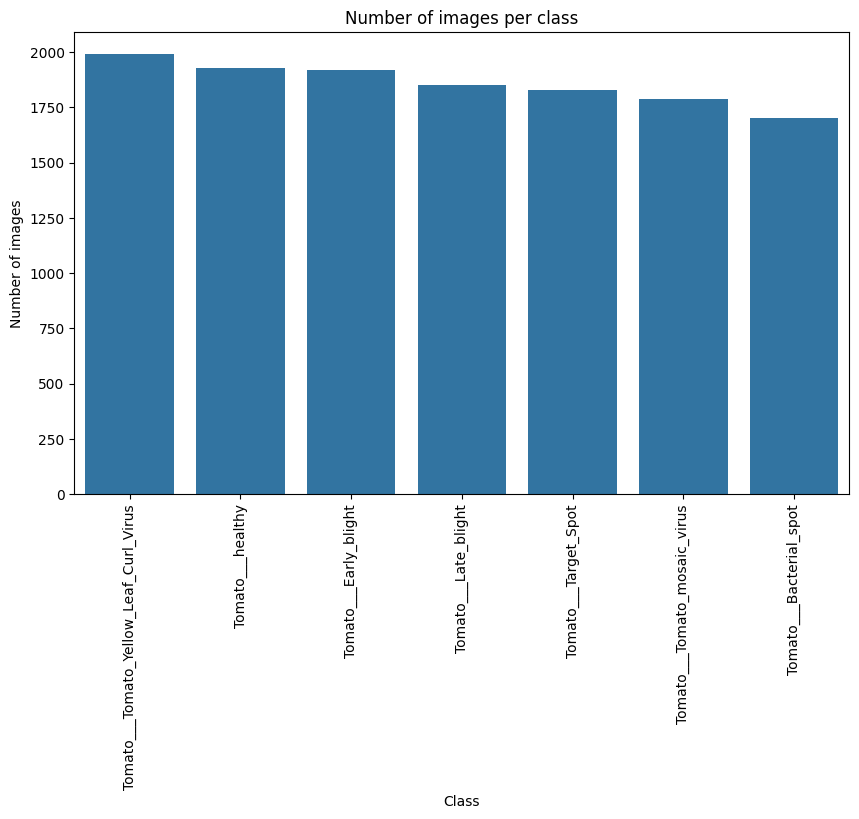

In [27]:
class_counts=pd.Series(y).value_counts()
print("Class distribution")
print(class_counts)

#plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index,y=class_counts.values)
plt.xticks(rotation=90)
plt.title("Number of images per class")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


In [28]:
#remove corrupted images
valid_images=[]
valid_labels=[]

for img,label in zip(x,y):
  if img.shape==(64,64,3):
    valid_images.append(img)
    valid_labels.append(label)

x=np.array(valid_images)
y=np.array(valid_labels)

print("Cleaned Data Shape:",x.shape)

Cleaned Data Shape: (13007, 64, 64, 3)


In [29]:
#Encode labels
le=LabelEncoder()
y_encoded=le.fit_transform(y)

#save class names for later use
class_names=le.classes_
class_names

array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U38')

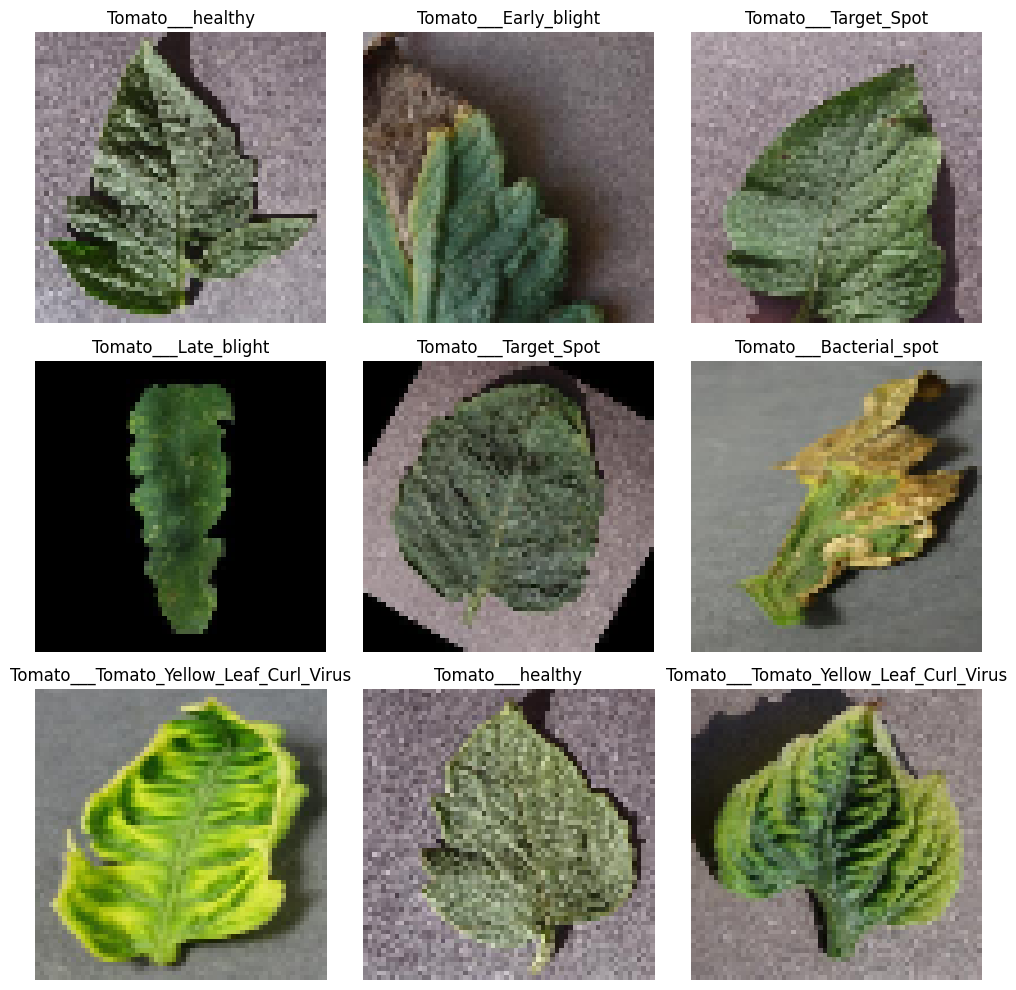

In [30]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
  idx=random.randint(0,len(x))
  plt.subplot(3,3,i+1)
  plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
  plt.title(class_names[y_encoded[idx]])
  plt.axis("off")
plt.tight_layout()
plt.show()

In [31]:
def extract_color_histogram(image,bins=(8,8,8)):

  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
  hist=  cv2.normalize(hist, hist).flatten()
  return hist

hist_features=[extract_color_histogram(img) for img in x]
x_features=np.array(hist_features)

In [32]:
x_features.shape

(13007, 512)

In [33]:
#choose model
model=SVC(kernel='rbf',C=10,gamma='scale')

In [34]:
#train/test split
x_tain,x_test,y_train,y_test=train_test_split(x_features,y_encoded,test_size=0.2,random_state=42)

#train model
model.fit(x_tain,y_train)

#predict
y_pred=model.predict(x_test)

Accuracy: 0.9769408147578785
F1 Score: 0.9768915921966557


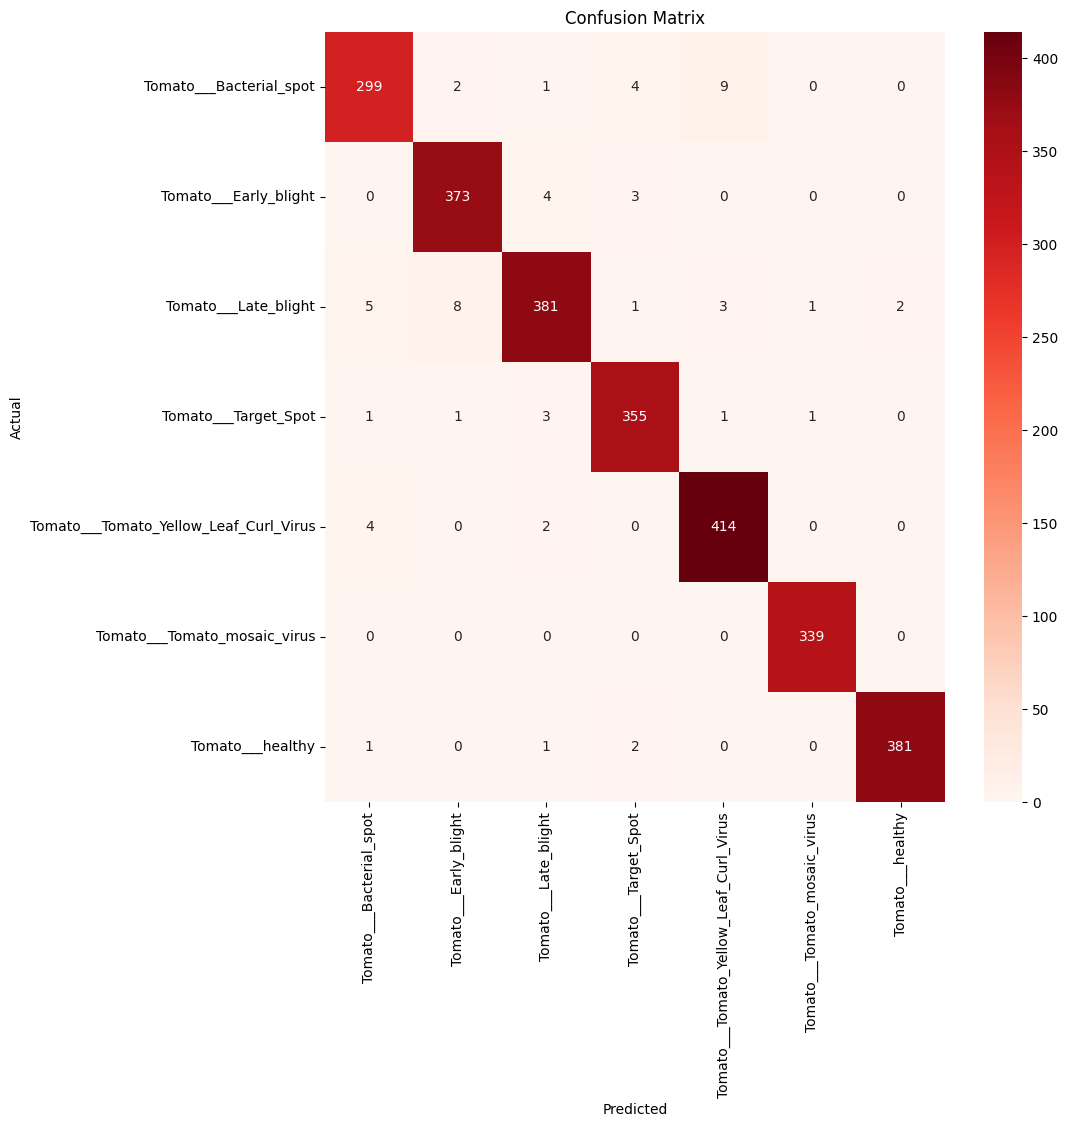

In [35]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

#Accuracy
acc=accuracy_score(y_test,y_pred)
print("Accuracy:",acc)

#F1 score
f1=f1_score(y_test,y_pred,average='weighted')
print("F1 Score:",f1)

#confusion matrix
cm=confusion_matrix(y_test,y_pred)

#plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Reds',xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [36]:
#classification report
print("Classification Report")
print(classification_report(y_test,y_pred,target_names=class_names))

Classification Report
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.96      0.95      0.96       315
                 Tomato___Early_blight       0.97      0.98      0.98       380
                  Tomato___Late_blight       0.97      0.95      0.96       401
                  Tomato___Target_Spot       0.97      0.98      0.98       362
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98       420
          Tomato___Tomato_mosaic_virus       0.99      1.00      1.00       339
                      Tomato___healthy       0.99      0.99      0.99       385

                              accuracy                           0.98      2602
                             macro avg       0.98      0.98      0.98      2602
                          weighted avg       0.98      0.98      0.98      2602

